In [ ]:
!pip install lime

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import lime
import lime.lime_tabular
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import cross_val_score

df = pd.read_csv('Phishing Websites Engineered.csv')

In [ ]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Assumptions

In [ ]:
# Assumption 1: Binary Outcome
print("Unique values in target:", y.unique())

Unique values in target: [-1  1]


In [ ]:
# Assumption 2: Independence of Observations
#The phishing dataset is assumed to have independent observations

Residual Calculation
      Actual  Predicted  Residuals
1335      -1         -1          0
807       -1         -1          0
1197      -1         -1          0
23         1          1          0
4195      -1         -1          0




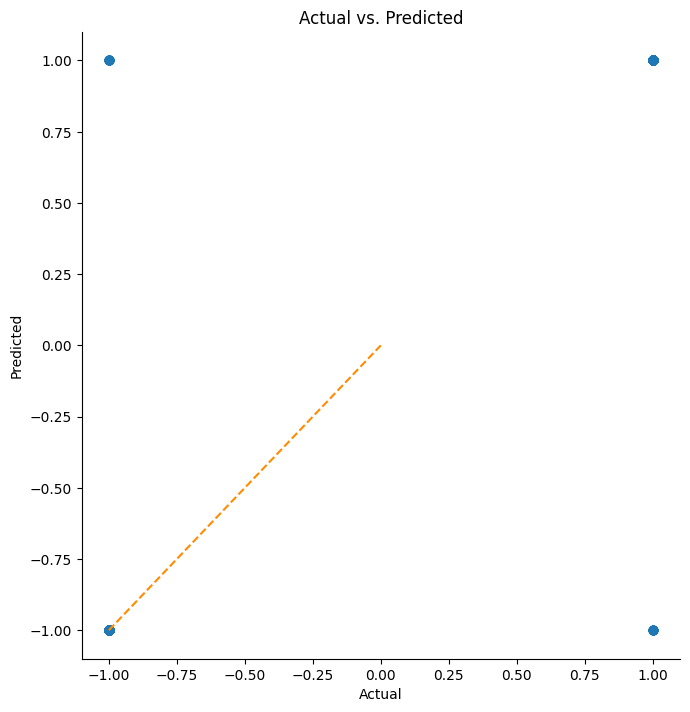

In [ ]:
#Assumption 3: Linear Relationship between the Target and the Feature

# Initializing Variable name like model, independent features and label name in the dataset
model = LogisticRegression()
features = df.drop('target', axis=1)
label = df['target']

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Prediction and a table of Actual vs Predicted
predictions = model.predict(X_test)
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

# Calculating Residuals
df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
print("Residual Calculation")
print(df_results.head())
print("\n")

# Plotting the actual vs predicted values
sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7) # Changed 'size' to 'height'

# Plotting the diagonal line
line_coords = np.arange(df_results.min().min(), df_results.max().max())
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')
plt.title('Actual vs. Predicted')
plt.show()


In [ ]:
# Assumption 4: Large Sample Size. At least 10 events per predictor for each class
print("Training set size:", len(X_train))
print("Events per predictor:", min(sum(y_train == 1), sum(y_train == -1)) / X_train.shape[1])

Training set size: 4679
Events per predictor: 67.05882352941177


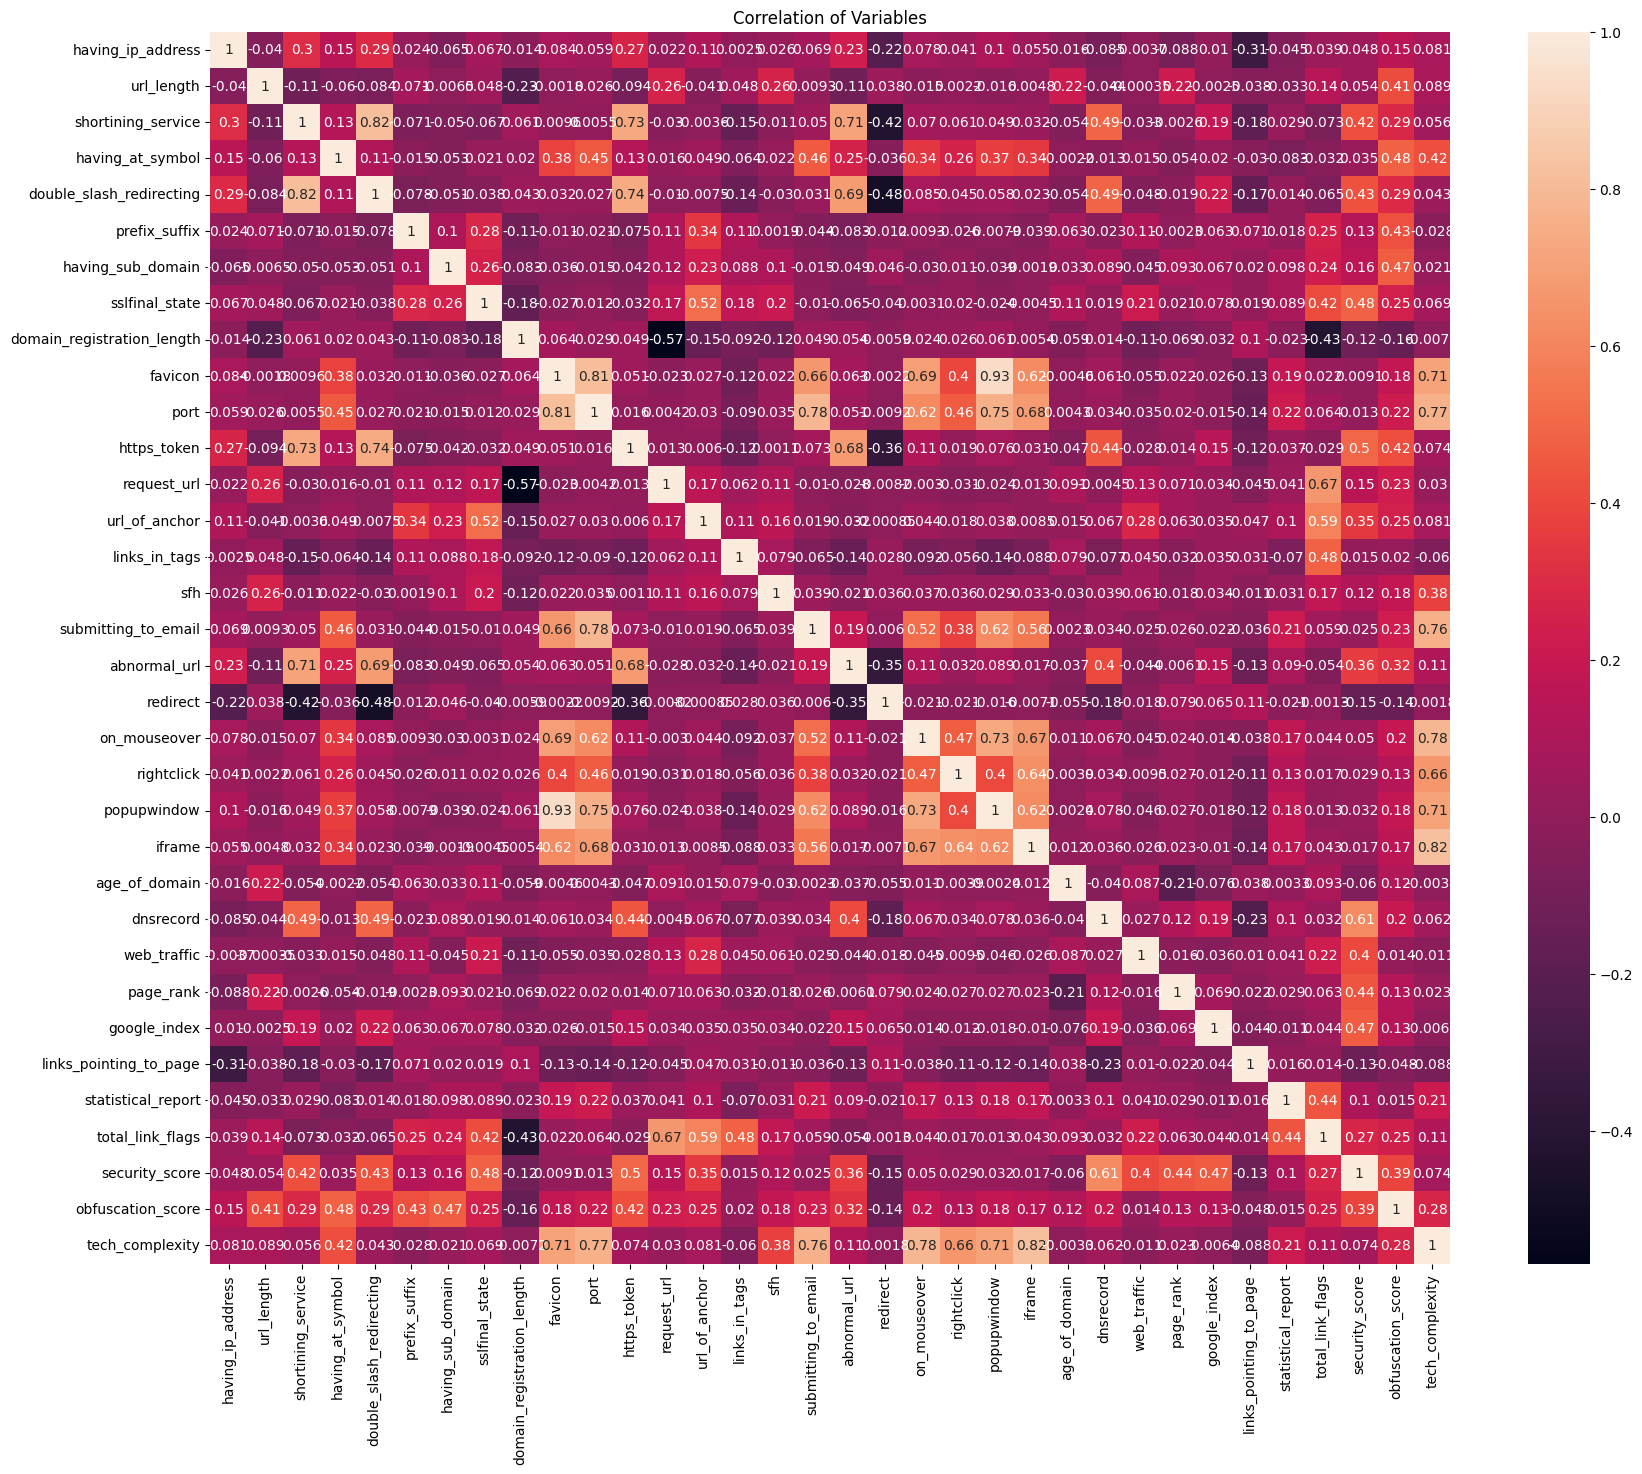

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


having_ip_address: 1.5123065862140366
url_length: inf
shortining_service: 8.093771285628327
having_at_symbol: 132374.7171486593
double_slash_redirecting: 8.403009604450672
prefix_suffix: 1917340.0249061307
having_sub_domain: 3115148.6581337443
sslfinal_state: 2065544.9695882709
domain_registration_length: 1.660316251787415
favicon: 15.13627488975522
port: 9.573924835931821
https_token: 103612.5565603055
request_url: 50298.460708810504
url_of_anchor: 4334555.812762007
links_in_tags: 305378.6918432228
sfh: inf
submitting_to_email: inf
abnormal_url: 5.162538756917732
redirect: 1.5162514407052532
on_mouseover: inf
rightclick: inf
popupwindow: 13.060109645995002
iframe: inf
age_of_domain: 1.2043117491642283
dnsrecord: 523240.43327543617
web_traffic: 177784.28206750855
page_rank: 182265.94153174202
google_index: 180938.9756916269
links_pointing_to_page: 1.66592327404099
statistical_report: 110306.03661035749
total_link_flags: 89118.63784138834
security_score: 796035.0411455712
obfuscation_sc

In [ ]:
# Assumption 5 : little/no multicollinearity
plt.figure(figsize = (20,16))  # Plotting the heatmap
feature_names = features.columns
sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
plt.title('Correlation of Variables')
plt.show()

print('Variance Inflation Factors (VIF)')
print('> 10: An indication that multicollinearity may be present')
print('> 100: Certain multicollinearity among the variables')
print('-----------------------------------------')

# Gathering the VIF for each variable
VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
for idx, vif in enumerate(VIF):
    print('{0}: {1}'.format(feature_names[idx], vif))

# Gathering and printing total cases of possible or definite multicollinearity
possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
definite_multicollinearity = sum([1 for vif in VIF if vif > 100])

print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
print()

if definite_multicollinearity == 0:
    if possible_multicollinearity == 0:
        print('Assumption satisfied')
    else:
        print('Assumption possibly satisfied')
        print()
        print('Coefficient interpretability may be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')
else:
    print('Assumption not satisfied')
    print()
    print('Coefficient interpretability will be problematic')
    print('Consider removing variables with a high Variance Inflation Factor (VIF)')


# Model training

In [ ]:
log_reg= LogisticRegression()
log_reg.fit(X_train, y_train)


LogisticRegression()

In [ ]:
y_pred = log_reg.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("Logistic Regression Results (All Features):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Logistic Regression Results (All Features):
Accuracy: 0.9308
Precision: 0.9150
Recall: 0.9400
F1 Score: 0.9274


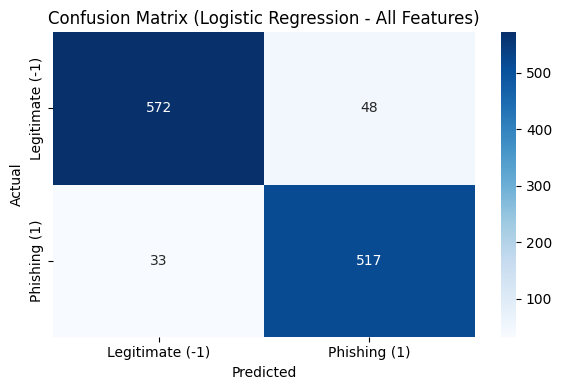

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate (-1)', 'Phishing (1)'], yticklabels=['Legitimate (-1)', 'Phishing (1)'])
plt.title('Confusion Matrix (Logistic Regression - All Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Interpretability Technique

## Feature Importance via Coefficients

In [ ]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values('Coefficient', ascending=False)

print("Top 5 Positive Coefficients:\n", coef_df.head())

Top 5 Positive Coefficients:
              Feature  Coefficient
5      prefix_suffix     2.310884
13     url_of_anchor     2.017918
7     sslfinal_state     1.494725
15               sfh     0.822428
30  total_link_flags     0.815023


## SHAP

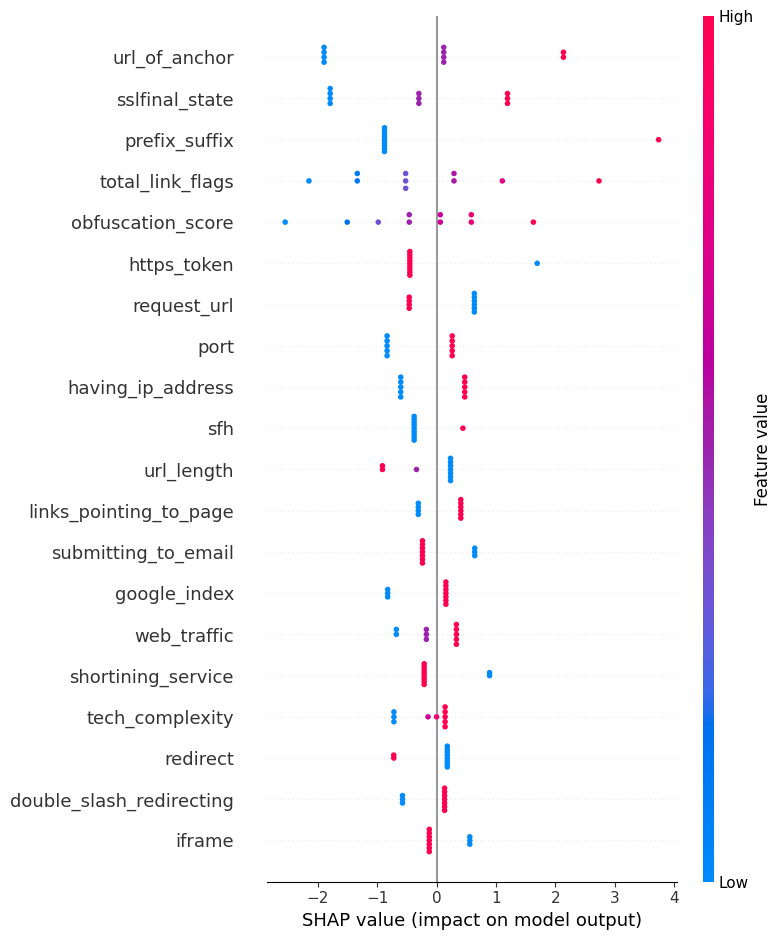

In [ ]:
background = shap.sample(X_train, 100, random_state=42)

# Create SHAP explainers for each model
log_reg_explainer = shap.LinearExplainer(log_reg, background)

# Pick a few test instances
sample = X_test.sample(10, random_state=42)

# Compute SHAP values
log_reg_shap_values = log_reg_explainer.shap_values(sample)

# Visualize summary plots
shap.summary_plot(log_reg_shap_values, sample, feature_names=sample.columns)


## LIME

In [ ]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=['Legitimate', 'Phishing'],
    mode='classification'
)


In [ ]:
def explain_instance_lime(model, model_name):
    i = np.random.randint(0, X_test.shape[0])
    exp = lime_explainer.explain_instance(
        X_test.iloc[i],
        model.predict_proba,
        num_features=10
    )
    print(f"\n🔍 LIME Explanation for model: {model_name} on instance {i}")
    exp.show_in_notebook(show_table=True)
    return exp

In [ ]:
# Explain one instance with each model
explain_instance_lime(log_reg, "Logistic Regression")

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.


🔍 LIME Explanation for model: Logistic Regression on instance 995


# LOFO

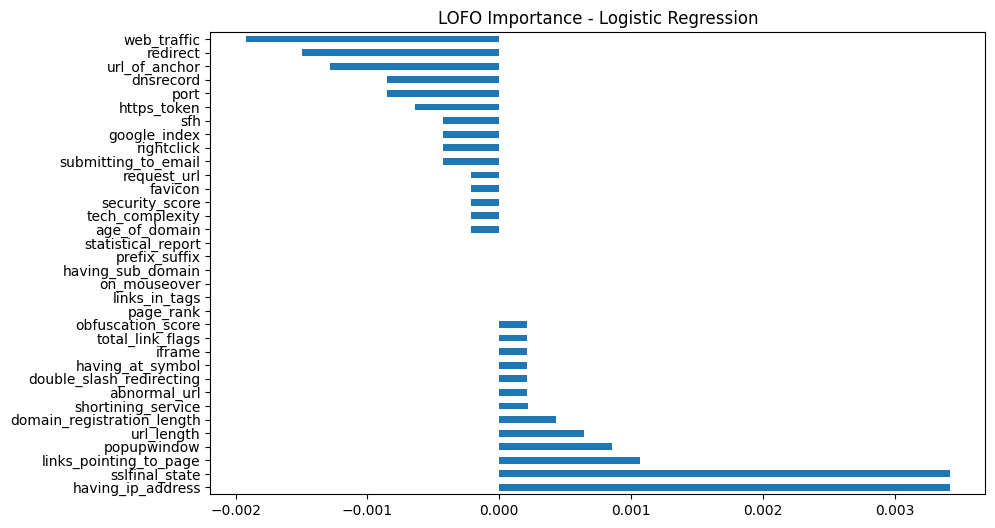

In [ ]:
baseline = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy').mean()

lofo_scores = {}
for col in X_train.columns:
    X_lofo = X_train.drop(columns=[col])
    score = cross_val_score(log_reg, X_lofo, y_train, cv=5, scoring='accuracy').mean()
    lofo_scores[col] = baseline - score

# Create DataFrame for LOFO scores and plot
lofo_df = pd.Series(lofo_scores).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
lofo_df.plot(kind='barh')
plt.title("LOFO Importance - Logistic Regression")
plt.show()

In [ ]:
print("\nTop 5 Features by LOFO Importance:")
print(lofo_df.head())


Top 5 Features by LOFO Importance:
having_ip_address         0.003420
sslfinal_state            0.003420
links_pointing_to_page    0.001069
popupwindow               0.000855
url_length                0.000641
dtype: float64
